# 04.Modelado predictivo con ML

### Importacion de la data

In [1]:
import pandas as pd
import numpy as np
df_news=pd.read_csv("C:/Repos/Projecto_TRM/Datos/noticias_bitcoin_sentimientos.csv")
df_btc=pd.read_csv("C:/Repos/Projecto_TRM/Datos/BTC_USD_Media_Movil.csv")
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1096 non-null   object 
 1   Close      1096 non-null   float64
 2   High       1096 non-null   float64
 3   Low        1096 non-null   float64
 4   Open       1096 non-null   float64
 5   Volume     1096 non-null   float64
 6   Close_7d   1090 non-null   float64
 7   Volume_7d  1090 non-null   float64
dtypes: float64(7), object(1)
memory usage: 68.7+ KB


In [2]:
df_news.head()

,fecha,titulo,descripcion,contenido,url,fuente,score
0,2025-04-07,Bitcoin price falls amid tariff market rout,"Bitcoin, the world's largest cryptocurrency by...","The price of bitcoin (BTC-USD), the world's la...",https://ca.finance.yahoo.com/news/bitcoin-pric...,Yahoo Canada Finance,-0.536233
1,2025-04-07,US crypto stocks plunge as bitcoin hits new 20...,U.S.-listed shares of crypto companies tumbled...,(Reuters) - U.S.-listed shares of crypto compa...,https://finance.yahoo.com/news/us-crypto-stock...,Yahoo Finance,-0.637867
2,2025-04-05,SpaceX tourists return to Earth after historic...,Bitcoin investor Chun Wang took three people o...,Four space tourists have safely arrived back o...,https://news.sky.com/story/spacex-tourists-ret...,Sky News,0.630636
3,2025-04-04,BlackRock buys $66M in Bitcoin amid market crash,BlackRock acquired $66 million in Bitcoin on t...,The sell-off in the stock market didn’t cool d...,https://finance.yahoo.com/news/blackrock-buys-...,Yahoo Finance,-0.137903
4,2025-04-04,Markets tumble as Trump launches ‘Unstoppable’...,Markets fell after Trump announced new tariffs...,"On April 3, markets worldwide dropped sharply ...",https://finance.yahoo.com/news/markets-tumble-...,Yahoo Finance,-0.489370


## Preprosesamiento de la data

In [3]:
df_news['fecha'] = pd.to_datetime(df_news['fecha'], format='%Y-%m-%d')

df_news_avg_score = df_news.groupby('fecha')['score'].mean().reset_index()

In [4]:
import plotly.express as px

fig = px.line(df_news_avg_score, x='fecha', y='score', title='Promedio del Score a lo Largo del Tiempo', markers=True)
fig.update_layout(xaxis_title='Fecha', yaxis_title='Avg Score', template='plotly_white')
fig.show()


## Implementacion del modelo

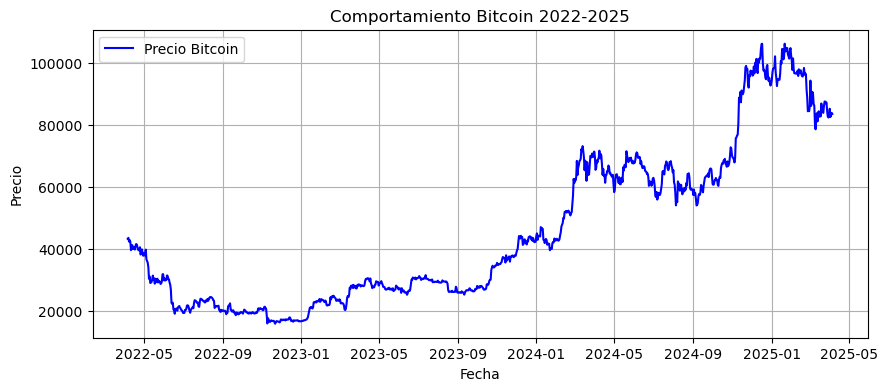

In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ensure 'Date' column is in datetime format and drop rows with NaN values
df_btc['Date'] = pd.to_datetime(df_btc['Date'], errors='coerce')
df_btc_cleaned = df_btc.dropna(subset=['Date', 'Close'])

plt.figure(figsize=(10, 4))
plt.plot(df_btc_cleaned['Date'], df_btc_cleaned['Close'], label='Precio Bitcoin', color='blue')
plt.title('Comportamiento Bitcoin 2022-2025')
plt.ylabel('Precio')
plt.xlabel('Fecha')
plt.legend()
plt.grid(True)
plt.show()


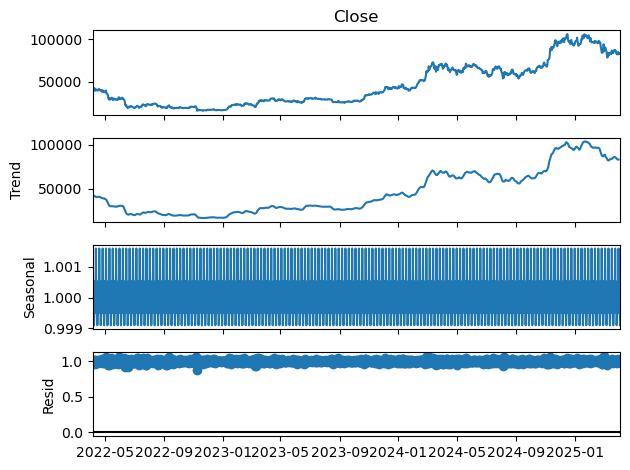

In [7]:
# Ensure the Date column is set as the index and drop rows with missing values
df_btc_cleaned = df_btc.dropna(subset=['Close']).set_index('Date')

# Perform seasonal decomposition
decompose_result = seasonal_decompose(df_btc_cleaned['Close'], model='multiplicative')
decompose_result.plot()
plt.tight_layout()
plt.show()

In [8]:
# Contar na
df_btc['Close'].isna().sum()
#Borrar na
df_btc.dropna(subset=['Close'], inplace=True)

In [9]:
# Paso 5: Test de Dickey-Fuller (estacionariedad)
result = adfuller(df_btc['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -0.41277959626419064
p-value: 0.9079430766815466


In [37]:
df_diff2 = df_btc['Close'].diff().diff().dropna()


In [38]:
result_diff2 = adfuller(df_diff2)
print(f'ADF Statistic (2nd diff): {result_diff2[0]}')
print(f'p-value (2nd diff): {result_diff2[1]}')


ADF Statistic (2nd diff): -14.555236970451977
p-value (2nd diff): 4.8933000347143896e-27


la serie no es estacionaria lo que indica que necesitamos transformarla antes de aplicar arima

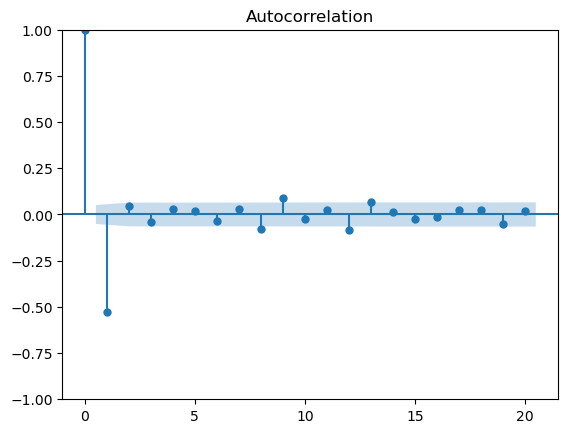

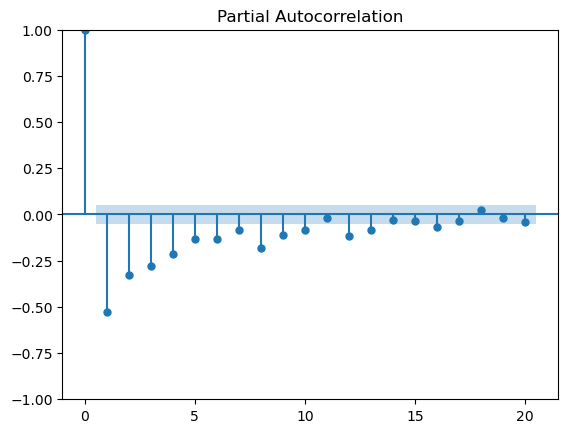

In [39]:
# Paso 7: ACF y PACF
plot_acf(df_diff2, lags=20)
plot_pacf(df_diff2, lags=20)
plt.show()


>>> ADF test original:
(-0.42751609159381077, 0.905402214465028, 13, 1446, {'1%': -3.434880391815318, '5%': -2.8635408625359315, '10%': -2.5678352438452814}, 24970.08012030241)
>>> ADF test 1ra diferencia:
(-6.861911709115791, 1.594515006901393e-09, 24, 1434, {'1%': -3.434918371231736, '5%': -2.8635576234668982, '10%': -2.5678441693558898}, 24950.82930447495)
>>> ADF test 2da diferencia:
(-14.555236970451977, 4.8933000347143896e-27, 24, 1433, {'1%': -3.434921564946909, '5%': -2.8635590328954197, '10%': -2.567844919904611}, 24969.305221609895)
                               SARIMAX Results                                
Dep. Variable:                BTC-USD   No. Observations:                 1168
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10042.480
Date:                Wed, 09 Apr 2025   AIC                          20090.960
Time:                        10:31:14   BIC                          20106.147
Sample:                    01-01-2021   HQIC            

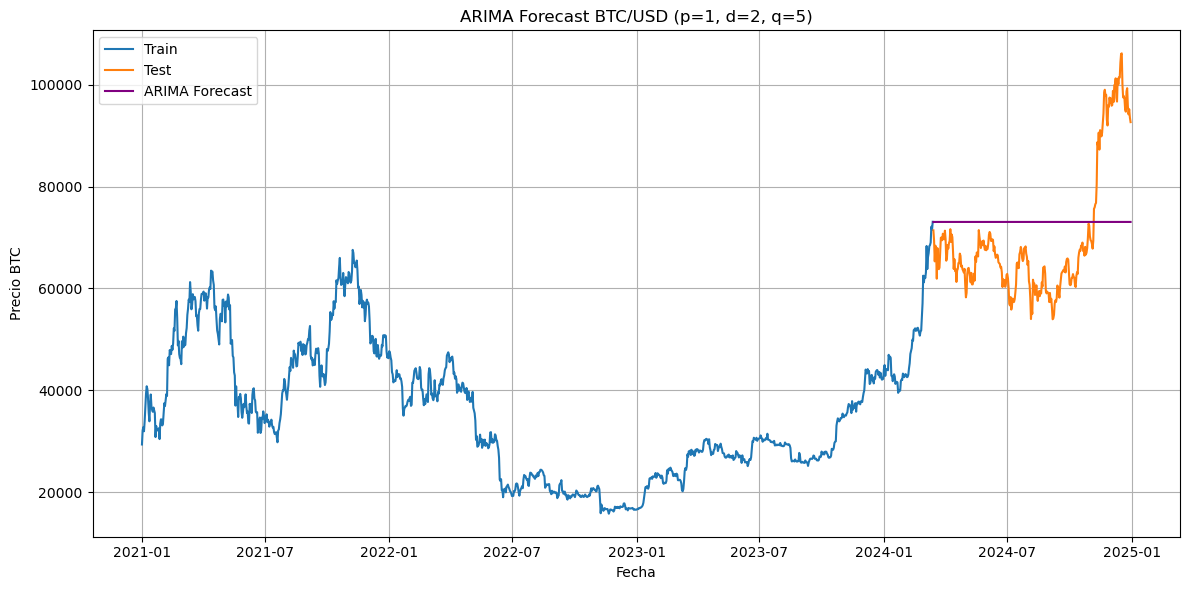

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller

# -----------------------------------------
# 1. Cargar datos
# -----------------------------------------
#df_btc.set_index("Date", inplace=True)
df_btc = df_btc.sort_index()

# -----------------------------------------
# 2. Evaluar estacionariedad y confirmar d=2
# -----------------------------------------
print(">>> ADF test original:")
print(adfuller(df_btc['Close']))
print(">>> ADF test 1ra diferencia:")
print(adfuller(df_btc['Close'].diff().dropna()))
print(">>> ADF test 2da diferencia:")
print(adfuller(df_btc['Close'].diff().diff().dropna()))

# -----------------------------------------
# 3. Separar datos
# -----------------------------------------
train_size = int(len(df_btc) * 0.8)
train = df_btc['Close'][:train_size]
test = df_btc['Close'][train_size:]

# -----------------------------------------
# 4. Entrenar modelo ARIMA manual
# -----------------------------------------
p, d, q = 1, 1, 1  # basado en pruebas previas
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

# -----------------------------------------
# 5. Forecast
# -----------------------------------------
n_test = len(test)
forecast = model_fit.forecast(steps=n_test)

# -----------------------------------------
# 6. Evaluación
# -----------------------------------------
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# -----------------------------------------
# 7. Visualización
# -----------------------------------------
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='purple')
plt.title("ARIMA Forecast BTC/USD (p=1, d=2, q=5)")
plt.xlabel("Fecha")
plt.ylabel("Precio BTC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_btc['Close'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -0.42751609159381077
p-value: 0.905402214465028


## Analisis con Prophet

In [ ]:
pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB 9.6 MB/s eta 0:00:02
   - -------------------------------------- 0.6/13.3 MB 7.7 MB/s eta 0:00:02
   ---- ----------------------------------- 1.4/13.3 MB 10.7 MB/s eta 0:00:02
   ----- ---------------------------------- 1.8/13.3 MB 10.5 MB/s eta 0:00:02
   ------- -------------------------------- 2.4/13.3 MB 11.1 MB/s eta 0:00:01
   -------- ------------------------------- 3.0/13.3 MB 11.2 MB/s eta 0:00:01
   ----------- ---------------------------- 3.7/13.3 MB 11.3 MB/s eta 0:00:01
   ------------- -------------------------- 4.6/13.3 MB 11.3 MB/s eta 0:00:01
   --------------- ------------------------ 5.3/13.3 MB 11.2 MB/s eta 0:00:01
   ----------------- ---------------------- 5.8/13.3 MB 11.3 MB/s eta 0:00:01
   ------------------- -------------------- 6.5/13.3 MB 11.5 MB/s eta 0:00:01
   --------------------- ------------------ 7.1/13.3 MB 11.4 MB/s eta 0:00

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error

#############################################
# 1) Prepare Data for Prophet
#############################################

# Suppose eth_df has a Date index and a column named 'price'.
# Example schema: eth_df.columns -> ['price'], eth_df.index -> DatetimeIndex

# Reset index to turn the Date into a column named 'ds'
prophet_df = df_btc[['Date','Close']].reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
# 'ds' must be datetime, 'y' is the numeric value to forecast
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Train/Test Split
train_size = int(len(prophet_df) * 0.8)
train_prophet = prophet_df[:train_size].copy()
test_prophet  = prophet_df[train_size:].copy()


print("[DEBUG] Prophet univariate data:")
print(prophet_df.head())

[DEBUG] Prophet univariate data:
   index         ds             y
0      0        NaT           NaN
1      1 2022-04-06  43206.738281
2      2 2022-04-07  43503.847656
3      3 2022-04-08  42287.664062
4      4 2022-04-09  42782.136719


In [ ]:
prophet_df.dropna(inplace=True)
prophet_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1096 entries, 1 to 1096
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   1096 non-null   int64         
 1   ds      1096 non-null   datetime64[ns]
 2   y       1096 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 34.2 KB


In [ ]:
train_prophet = train_prophet[['ds', 'y']]
test_prophet = test_prophet[['ds', 'y']]


In [ ]:
print(train_prophet.head())
print(test_prophet.head())

          ds             y
0        NaT           NaN
1 2022-04-06  43206.738281
2 2022-04-07  43503.847656
3 2022-04-08  42287.664062
4 2022-04-09  42782.136719
            ds             y
877 2024-08-29  59388.179688
878 2024-08-30  59119.476562
879 2024-08-31  58969.898438
880 2024-09-01  57325.488281
881 2024-09-02  59112.480469


In [ ]:
import prophet
print(prophet.__version__)


1.1.6


In [ ]:
pip install cmdstanpy

In [ ]:
pip install --upgrade prophet


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # <-- faltaba esto

# Inicializar modelo Prophet
m_baseline = Prophet(daily_seasonality=True)
m_baseline.fit(train_prophet)

# Crear un dataframe futuro con la longitud del test
future_baseline = m_baseline.make_future_dataframe(periods=len(test_prophet))
forecast_baseline = m_baseline.predict(future_baseline)

# Evaluar RMSE en el test
merged_baseline = pd.merge(
    test_prophet[['ds', 'y']],
    forecast_baseline[['ds', 'yhat']],
    on='ds', how='left'
)
rmse_baseline = np.sqrt(mean_squared_error(merged_baseline['y'], merged_baseline['yhat']))
print(f"\n[DEBUG] Baseline Prophet RMSE: {rmse_baseline:.4f}")

# Graficar el forecast
fig = m_baseline.plot(forecast_baseline)
plt.title("Prophet Baseline Forecast (No Sentiment)")
plt.show()


AttributeError: 'Prophet' object has no attribute 'stan_backend'